<a href="https://colab.research.google.com/github/Enock-Antonio/Enock-Antonio/blob/main/Deepfake_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
philosopher0808_real_vs_ai_generated_faces_dataset_path = kagglehub.dataset_download('philosopher0808/real-vs-ai-generated-faces-dataset')

print('Data source import complete.')


Data source import complete.


In [3]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import  cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from keras.models import load_model


In [4]:
data_dir = '/kaggle/input/real-vs-ai-generated-faces-dataset/dataset/dataset'

In [5]:
os.listdir(data_dir)

['validate', 'test', 'train']

In [6]:
print(len( os.listdir((os.path.join(data_dir,'train','0')))))
print(len( os.listdir((os.path.join(data_dir,'train','1')))))

42000
30574


In [7]:
class DataGenerator():
    def __init__(self, batch_size, target_size=(256, 256)):
        self.batch_size = batch_size
        self.target_size = target_size

    def generate_data(self, subset, directory):

        print("Loading", subset, "...")

        shuffle = False
        if subset == 'train' or subset == 'validation':
            shuffle = True

        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='categorical',
            class_names=['0', '1'],
            color_mode='rgb',
            batch_size=self.batch_size,
            image_size=self.target_size,
            shuffle=shuffle,
            seed=42,
        )

        return dataset

In [8]:
def augmentation_layer(dataset):
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomContrast(0.2),
            tf.keras.layers.RandomBrightness(0.2),
        ]
    )
    dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
    return dataset # Return the augmented dataset

In [9]:
batch_size = 256
target_size = (256, 256)
data_gen = DataGenerator(batch_size, target_size)

train_set = data_gen.generate_data('train', '/kaggle/input/real-vs-ai-generated-faces-dataset/dataset/dataset/train')
val_set = data_gen.generate_data('validation', '/kaggle/input/real-vs-ai-generated-faces-dataset/dataset/dataset/validate')
test_set = data_gen.generate_data('test', '/kaggle/input/real-vs-ai-generated-faces-dataset/dataset/dataset/test')

Loading train ...
Found 72574 files belonging to 2 classes.
Loading validation ...
Found 24190 files belonging to 2 classes.
Loading test ...
Found 24190 files belonging to 2 classes.


In [10]:
# get labels for evaluating step
labels = np.array([])
for x, y in test_set:
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

print(len(labels))
train_set = augmentation_layer(train_set)


24190


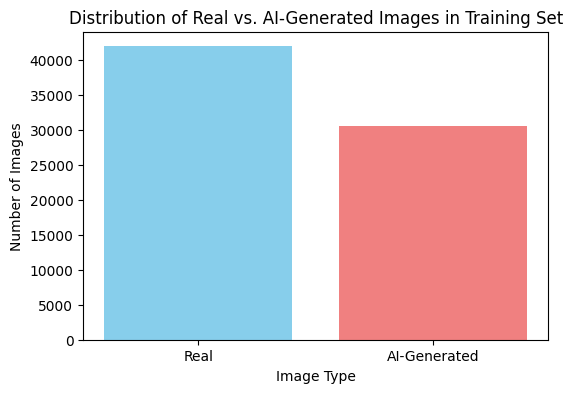

In [11]:
# Basic EDA - Visualize class distribution
real_count = len(os.listdir(os.path.join(data_dir, 'train', '0')))
ai_count = len(os.listdir(os.path.join(data_dir, 'train', '1')))
labels = ['Real', 'AI-Generated']
counts = [real_count, ai_count]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['skyblue', 'lightcoral'])
plt.title('Distribution of Real vs. AI-Generated Images in Training Set')
plt.xlabel('Image Type')
plt.ylabel('Number of Images')
plt.show()

Sample images from the training set:


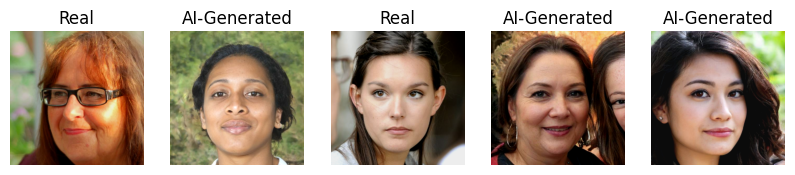

In [12]:
# Visualize sample images from the training set
def plot_sample_images(dataset, num_images=5):
  plt.figure(figsize=(10, 10))
  for images, labels in dataset.take(1):
    for i in range(num_images):
      ax = plt.subplot(1, num_images, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      class_label = "Real" if np.argmax(labels[i]) == 0 else "AI-Generated"
      plt.title(class_label)
      plt.axis("off")
  plt.show()
print("Sample images from the training set:")
plot_sample_images(train_set)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Function to flatten and preprocess image data for PCA
def preprocess_for_pca(dataset):
  images = []
  for batch in dataset.unbatch().take(1000): # Take a subset for faster processing
    image = batch[0].numpy()
    images.append(image.flatten()) # Flatten the image
  return np.array(images)

In [14]:
# Get image data from the training set for PCA
train_images_pca = preprocess_for_pca(train_set)

# Standardize the data
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images_pca)

# Apply PCA
n_components = 50  # Choose the number of components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(train_images_scaled)

print(f"Original number of features: {train_images_pca.shape[1]}")
print(f"Reduced number of features after PCA: {principal_components.shape[1]}")

Original number of features: 196608
Reduced number of features after PCA: 50


In [15]:
# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio by each component: {explained_variance}")
print(f"Total explained variance by {n_components} components: {np.sum(explained_variance)}")

Explained variance ratio by each component: [0.28169897 0.10968224 0.05679805 0.04618557 0.04026952 0.0366978
 0.02330321 0.01644683 0.01409406 0.01261849 0.01144479 0.01049402
 0.0096051  0.00918594 0.00834087 0.00785312 0.0073353  0.00671931
 0.0061252  0.00588543 0.00561102 0.00499785 0.00480753 0.00452893
 0.00443581 0.00431446 0.00393446 0.0039043  0.00380598 0.00363578
 0.00354852 0.00333699 0.00319825 0.00304364 0.00294269 0.00291498
 0.00279665 0.00266641 0.00258419 0.00245467 0.00240369 0.00232682
 0.00227153 0.0022335  0.00211972 0.00198505 0.00197499 0.00195743
 0.00189214 0.00183482]
Total explained variance by 50 components: 0.81524658203125


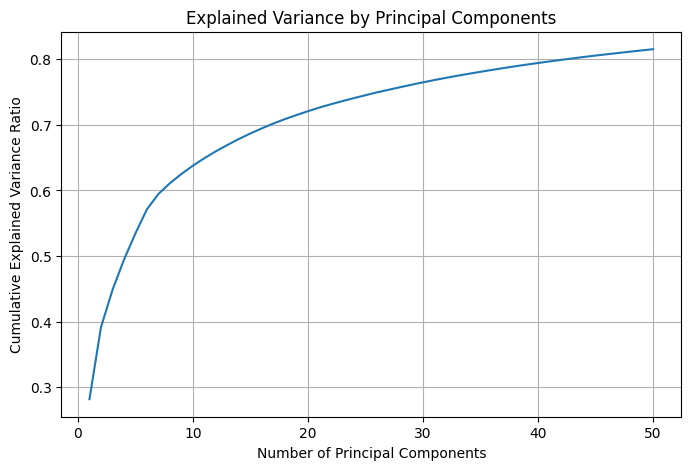

In [16]:
# Plot the explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), np.cumsum(explained_variance))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

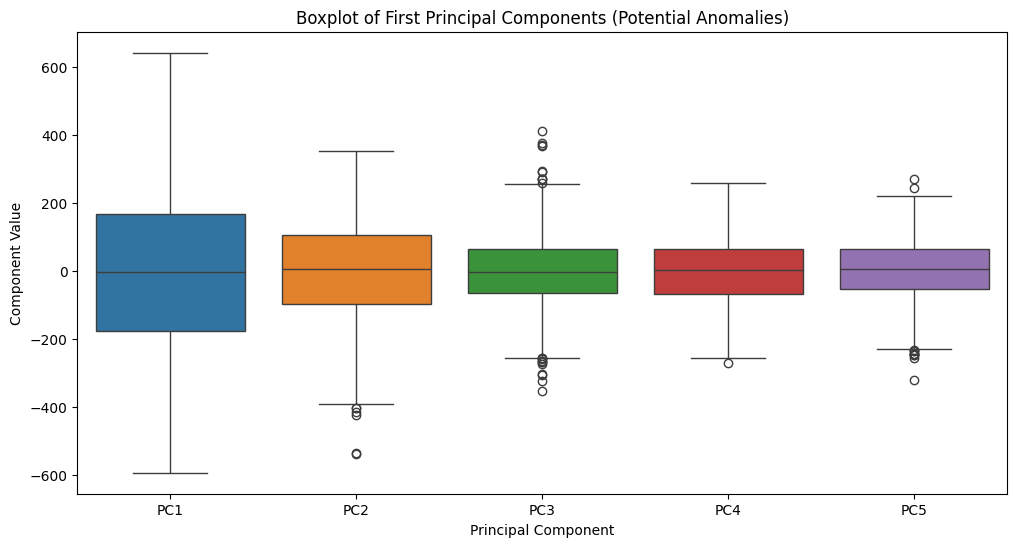

In [17]:
import pandas as pd
num_components_to_plot = 5
pca_df = pd.DataFrame(data=principal_components[:, :num_components_to_plot],
                      columns=[f'PC{i+1}' for i in range(num_components_to_plot)])

# Generate boxplots for the first few principal components to identify potential anomalies (outliers)
plt.figure(figsize=(12, 6))
sns.boxplot(data=pca_df)
plt.title('Boxplot of First Principal Components (Potential Anomalies)')
plt.xlabel('Principal Component')
plt.ylabel('Component Value')
plt.show()

In [18]:
from scipy import stats

# Dummy data for 'feature_X'
np.random.seed(42)
real_feature_x = np.random.normal(loc=10, scale=2, size=real_count)
ai_feature_x = np.random.normal(loc=11, scale=2, size=ai_count)

# Perform an independent samples t-test
# Null hypothesis: The mean of feature_X is the same for Real and AI-Generated images.
# Alternative hypothesis: The mean of feature_X is different for Real and AI-Generated images.
t_statistic, p_value = stats.ttest_ind(real_feature_x, ai_feature_x)

print("\nHypothesis Testing (Independent Samples t-test on a dummy feature):")
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")


Hypothesis Testing (Independent Samples t-test on a dummy feature):
T-statistic: -67.0101
P-value: 0.0000


Reject the null hypothesis. There is a significant difference in the mean of the dummy feature between Real and AI-Generated images (p < 0.05).

Sample images from the validation set:


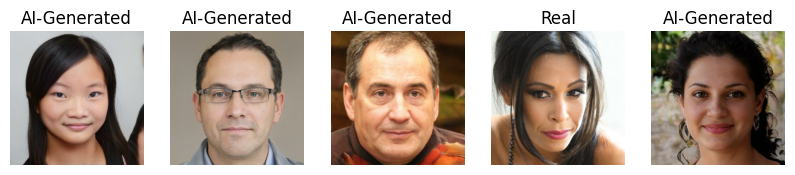


Sample images from the test set:


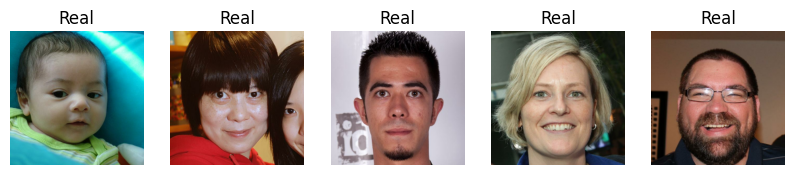

In [19]:
alpha = 0.05  # Significance level
if p_value < alpha:
    print(f"Reject the null hypothesis. There is a significant difference in the mean of the dummy feature between Real and AI-Generated images (p < {alpha}).")
else:
    print(f"Fail to reject the null hypothesis. There is no significant difference in the mean of the dummy feature between Real and AI-Generated images (p >= {alpha}).")

# Visualize sample images from the validation set
print("\nSample images from the validation set:")
plot_sample_images(val_set)

# Visualize sample images from the test set
print("\nSample images from the test set:")
plot_sample_images(test_set)

In [20]:
# Model Architecture Selection and Design (CNN)
def build_cnn_model(input_shape=(256, 256, 3)):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')  # 2 classes (Real/AI)
    ])
    return model

# Build the model
model = build_cnn_model()

# Display the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,234 (56.61 MB)

 Trainable params: 14,839,234 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Model Compilation
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks: Early Stopping and Model Checkpoint (optional)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_cnn_model.h5',
    monitor='val_loss',
    save_best_only=True
)

callbacks = [early_stopping, model_checkpoint]

In [ ]:
# Model Training
epochs = 20

history = model.fit(
    train_set,
    epochs=epochs,
    validation_data=val_set,
    callbacks=callbacks
)

Epoch 1/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6538 - loss: 37.5120

284/284 ━━━━━━━━━━━━━━━━━━━━ 649s 2s/step - accuracy: 0.6539 - loss: 37.4075 - val_accuracy: 0.7816 - val_loss: 0.4691
Epoch 2/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7615 - loss: 0.5103

284/284 ━━━━━━━━━━━━━━━━━━━━ 451s 2s/step - accuracy: 0.7615 - loss: 0.5103 - val_accuracy: 0.7979 - val_loss: 0.4446
Epoch 3/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7751 - loss: 0.4838

284/284 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.7751 - loss: 0.4838 - val_accuracy: 0.8185 - val_loss: 0.4107
Epoch 4/20
231/284 ━━━━━━━━━━━━━━━━━━━━ 1:16 1s/step - accuracy: 0.7956 - loss: 0.4473

In [ ]:
# Model Evaluation
loss, accuracy = model.evaluate(test_set)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [1]:
# Classification Report and Confusion Matrix
# Get predictions for the test set
predictions = model.predict(test_set)
predicted_classes = np.argmax(predictions, axis=1)

# The true labels for the test set were already extracted
true_classes = labels.astype(int)

# Ensure the number of predictions matches the number of true labels
if len(predicted_classes) != len(true_classes):
    print("Warning: Number of predictions does not match the number of true labels.")
    # You might need to re-extract test labels if the dataset structure or processing changed
    test_labels_new = np.array([])
    for x, y in test_set:
        test_labels_new = np.concatenate([test_labels_new, np.argmax(y.numpy(), axis=-1)])
    true_classes = test_labels_new.astype(int)


# Generate Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=['Real (0)', 'AI-Generated (1)']))

NameError: name 'model' is not defined

In [ ]:
# Generate Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'AI-Generated'], yticklabels=['Real', 'AI-Generated'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()